## 学习和使用Adaboost

* 复习教材第七章内容，调试运行相关代码
* 查阅scikit-learn工具包中Adaboost和其他提升方法学习器的相关说明，了解相关函数使用方法。
* 完成作业三

# 集成学习

将不同的分类器组合起来，组合的结果称为集成方法或元算法。使用集成方法时会有多种形式，可以是不同方法的集成，也可以是同一算法在不同设置下的集成，还可以是数据集不同部分分配给不同分类器之后的集成。

* bagging：bootstrtap aggregating 自举汇聚法。从原始数据集选择S次后得到S个新数据集的一种技术。

    S个数据集建好之后，将某个学习算法分别作用于每个数据集就得到了S个分类器。选择分类器投票结果中最多的类别作为最后的分类结果。

    更先进的bagging方法：[随机森林](http://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm)

* boosting：相比bagging，训练器是串行训练的，每个新分类器类型一致，且是根据已训练出的分类器性能进行训练（集中关注被已有分类器错分的哪些数据）。

    boosting各个分类器权重并不相等，每个权重代表的是其对应分类器在上一轮迭代中的成功度。
    
    Adaboost：adaptive boosting自适应boosting——boosting方法中一个最流行的版本
    

## Adaboost

Adaboost：adaptive boosting自适应boosting

每个分类器都分配了一个权重值 $\alpha$, 基于错误率 $\epsilon$ 进行计算。

$$
\epsilon = \dfrac{\text{未正确分类的样本数目}}{\text{所有样本数目}}
\\
\alpha = \dfrac{1}{2} \ln \left(\dfrac{1-\epsilon}{\epsilon}\right)
$$

训练时，对每个样本分配一个权重，组成权重向量 $D$ 。训练计算出 $\alpha$ 之后，可以对权重向量 $D$ 进行更新，升高误分样本权重，降低正分样本权重。

正确分类的样本权重 $D_i^{(t+1)} = \dfrac{D_i^{(t)}e^{-\alpha}}{\text{Sum}(D)}$

错误分类的样本权重 $D_i^{(t+1)} = \dfrac{D_i^{(t)}e^{\alpha}}{\text{Sum}(D)}$

## 基于单层决策树构建弱分类器

单层决策树，也称决策树桩，只有一次分裂过程。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def loadSimpData():
    datMat = np.matrix([[ 1. ,  2.1],
        [ 2. ,  1.1],
        [ 1.3,  1. ],
        [ 1. ,  1. ],
        [ 2. ,  1. ]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat,classLabels

In [3]:
dataMat,classLabels = loadSimpData()

![](https://downloads.mariozzj.cn/img/picgo/20210424141441.png?imageMogr2/thumbnail/!30p)

In [4]:
# 7-1 单层决策树生成函数

def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):#just classify the data
    retArray = np.ones((np.shape(dataMatrix)[0],1))
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0
    return retArray
    

def buildStump(dataArr,classLabels,D):
    dataMatrix = np.mat(dataArr); labelMat = np.mat(classLabels).T
    m,n = np.shape(dataMatrix)
    numSteps = 10.0; bestStump = {}; bestClasEst = np.mat(np.zeros((m,1)))
    minError = np.inf #init error sum, to +infinity
    for i in range(n):#loop over all dimensions
        rangeMin = dataMatrix[:,i].min(); rangeMax = dataMatrix[:,i].max();
        stepSize = (rangeMax-rangeMin)/numSteps
        for j in range(-1,int(numSteps)+1):#loop over all range in current dimension
            for inequal in ['lt', 'gt']: #go over less than and greater than
                threshVal = (rangeMin + float(j) * stepSize)
                predictedVals = stumpClassify(dataMatrix,i,threshVal,inequal)#call stump classify with i, j, lessThan
                errArr = np.mat(np.ones((m,1)))
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T*errArr  #calc total error multiplied by D
#                 print("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError))
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump,minError,bestClasEst

In [5]:
D = np.mat(np.ones((5,1))/5)
buildStump(dataMat,classLabels,D)

({'dim': 0, 'thresh': 1.3, 'ineq': 'lt'},
 matrix([[0.2]]),
 array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

上述单层决策树的生成函数是决策树的一个简化版本。它就是所谓的弱学习器，即弱分类算
法。

## 完整Adaboost算法实现

伪代码：
> * 对每次迭代：
>   * 利用buildStump()函数找到最佳的单层决策树
>   * 将最佳单层决策树加入到单层决策树数组
>   * 计算alpha
>   * 计算新的权重向量D
>   * 更新累计类别估计值
>   * 如果错误率等于0.0，则退出循环



In [6]:
def adaBoostTrainDS(dataArr,classLabels,numIt=40):
    weakClassArr = []
    m = np.shape(dataArr)[0]
    D = np.mat(np.ones((m,1))/m)   #init D to all equal
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(numIt):
        bestStump,error,classEst = buildStump(dataArr,classLabels,D)#build Stump
#         print("D:",D.T)
        alpha = float(0.5*np.log((1.0-error)/max(error,1e-16)))#calc alpha, throw in max(error,eps) to account for error=0
        bestStump['alpha'] = alpha  
        weakClassArr.append(bestStump)                  #store Stump Params in Array
#         print("classEst: ",classEst.T)
        expon = np.multiply(-1*alpha*np.mat(classLabels).T,classEst) #exponent for D calc, getting messy
        D = np.multiply(D,np.exp(expon))                              #Calc New D for next iteration
        D = D/D.sum()
        #calc training error of all classifiers, if this is 0 quit for loop early (use break)
        aggClassEst += alpha*classEst
#         print("aggClassEst: ",aggClassEst.T)
        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T,np.ones((m,1)))
        errorRate = aggErrors.sum()/m
        print("total error: ",errorRate)
        if errorRate == 0.0: break
#     return weakClassArr,aggClassEst
    return weakClassArr

In [7]:
classifierArray = adaBoostTrainDS(dataMat, classLabels, 9)

total error:  0.2
total error:  0.2
total error:  0.0


In [8]:
classifierArray

[{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.6931471805599453},
 {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565},
 {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.8958797346140273}]

## 测试：基于Adaboost的分类

 $H(\boldsymbol{x}) = \sum\limits_{t=1}^T \alpha_th_t(\boldsymbol{x}); \ \ \text{sign}(H(\boldsymbol{x}))$ 
 
 对于生成的每一个决策树桩，使所有样本进行测试，通过加性模型计算整体预测结果，再使用符号函数进行输出。

In [9]:
def adaClassify(datToClass,classifierArr):
    dataMatrix = np.mat(datToClass)#do stuff similar to last aggClassEst in adaBoostTrainDS
    m = np.shape(dataMatrix)[0]
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix,classifierArr[i]['dim'],\
                                 classifierArr[i]['thresh'],\
                                 classifierArr[i]['ineq'])#call stump classify
        aggClassEst += classifierArr[i]['alpha']*classEst
#         print(aggClassEst)
    return np.sign(aggClassEst)

In [10]:
dataArr,labelArr = loadSimpData()

classifierArr = adaBoostTrainDS(dataArr, labelArr, 30)
adaClassify([0,0],classifierArr)

total error:  0.2
total error:  0.2
total error:  0.0


matrix([[-1.]])

In [11]:
adaClassify([[5,5],[0,0]],classifierArr)

matrix([[ 1.],
        [-1.]])

## 实战：马疝气病数据集预测存活

In [12]:
# 7-4 自适应数据加载函数

def loadDataSet(fileName):      #general function to parse tab -delimited floats
    numFeat = len(open(fileName).readline().split('\t')) #get number of fields 
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr =[]
        curLine = line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat

In [13]:
datArr, labelArr = loadDataSet('./data/horseColicTraining2.txt')
classifierArray = adaBoostTrainDS(datArr, labelArr, 10)

total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.24749163879598662
total error:  0.24749163879598662
total error:  0.25418060200668896
total error:  0.2408026755852843
total error:  0.2408026755852843
total error:  0.22073578595317725
total error:  0.24749163879598662
total error:  0.23076923076923078


In [14]:
testArr,testLabelArr = loadDataSet('./data/horseColicTest2.txt')
prediction10 = adaClassify(testArr, classifierArray)
errArr = np.mat(np.ones((67,1)))
errArr[prediction10!=np.mat(testLabelArr).T].sum()

16.0

## 非均衡分类问题

混淆矩阵：针对一个二类问题，根据某一实例的分类结果可被分为正例和负例。

|          | Predict Y            | Predict N            |
| -------- | -------------------- | -------------------- |
| Actual Y | True Positive真正例  | False Negative假反例 |
| Actual N | False Positive假正例 | True Negative真反例  |

模型评价 $\text{Accuracy}=\dfrac{TP+TN}{TP+TN+FP+FN}$ 

precision(精准率)=$\dfrac{TP}{TP+FP}$, recall(召回率)=$\dfrac{TP}{TP+FN}$,F1=$\dfrac{2*precision*recall}{precision+recall}$


另一个用于度量分类中的非均衡性工具是ROC曲线，ROC代表接收者操作特征（Reciever Operating Characteristic）

![](https://downloads.mariozzj.cn/img/picgo/20210424213821.png?imageMogr2/thumbnail/!30p)

横轴是FP比例（ $=\dfrac{\text{FP}}{\text{FP+TN}}$ ），纵轴是TP比例（ $=\dfrac{\text{TP}}{\text{FP+TN}}$ ）。左下角的点是将所有样例判为负例的情况，右上角是将所有样例判为正例的情况，虚线是随机猜测的结果曲线。在理想的情况下，最佳的分类器应该尽可能地处于左上角。

对不同的ROC曲线进行比较的一个指标是曲线下的面积（AUC，Area Under the Curve）。AUC给出的是分类器的平均性能值，完美为1，随机猜测为0.5。

In [15]:
## 7-5 ROC曲线的绘制及AUC计算函数

def plotROC(predStrengths, classLabels):
    cur = (1.0,1.0) #cursor
    ySum = 0.0 #variable to calculate AUC
    numPosClas = sum(np.array(classLabels)==1.0)
    yStep = 1/float(numPosClas); xStep = 1/float(len(classLabels)-numPosClas)
    sortedIndicies = predStrengths.argsort()#get sorted index, it's reverse
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    #loop through all the values, drawing a line segment at each point
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0; delY = yStep;
        else:
            delX = xStep; delY = 0;
            ySum += cur[1]
        #draw line from cur to (cur[0]-delX,cur[1]-delY)
        ax.plot([cur[0],cur[0]-delX],[cur[1],cur[1]-delY], c='b')
        cur = (cur[0]-delX,cur[1]-delY)
    ax.plot([0,1],[0,1],'b--')
    plt.xlabel('False positive rate'); plt.ylabel('True positive rate')
    plt.title('ROC curve for AdaBoost horse colic detection system')
    ax.axis([0,1,0,1])
    plt.show()
    print("the Area Under the Curve is: ",ySum*xStep)

In [16]:
def adaBoostTrainDS(dataArr,classLabels,numIt=40):
    weakClassArr = []
    m = np.shape(dataArr)[0]
    D = np.mat(np.ones((m,1))/m)   #init D to all equal
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(numIt):
        bestStump,error,classEst = buildStump(dataArr,classLabels,D)#build Stump
#         print("D:",D.T)
        alpha = float(0.5*np.log((1.0-error)/max(error,1e-16)))#calc alpha, throw in max(error,eps) to account for error=0
        bestStump['alpha'] = alpha  
        weakClassArr.append(bestStump)                  #store Stump Params in Array
#         print("classEst: ",classEst.T)
        expon = np.multiply(-1*alpha*np.mat(classLabels).T,classEst) #exponent for D calc, getting messy
        D = np.multiply(D,np.exp(expon))                              #Calc New D for next iteration
        D = D/D.sum()
        #calc training error of all classifiers, if this is 0 quit for loop early (use break)
        aggClassEst += alpha*classEst
#         print("aggClassEst: ",aggClassEst.T)
        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T,np.ones((m,1)))
        errorRate = aggErrors.sum()/m
        print("total error: ",errorRate)
        if errorRate == 0.0: break
    return weakClassArr,aggClassEst

total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.24749163879598662
total error:  0.24749163879598662
total error:  0.25418060200668896
total error:  0.2408026755852843
total error:  0.2408026755852843
total error:  0.22073578595317725
total error:  0.24749163879598662
total error:  0.23076923076923078


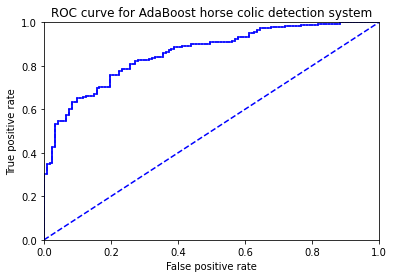

the Area Under the Curve is:  0.8582969635063604


In [17]:
datArr, labelArr = loadDataSet('./data/horseColicTraining2.txt')
classifierArray, aggClassEst = adaBoostTrainDS(datArr,labelArr,10)
plotROC(aggClassEst.T,labelArr)

# sklearn集成学习

```Python
class sklearn.ensemble.AdaBoostClassifier(base_estimator=None, *, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None)
```

* `base_estimator`: 默认None。如果设为None，基学习器则被指定为[DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)，`max_depth`设为1.(即决策树桩)
* `n_estimators`：boosting过程被终止的最大估计器数量（当然，完全拟合时会直接终止）
* `learning_rate`：学习率。
* `algorithm`：提升算法。如果选用`SAMMER.R`，`base_estimator`必须支持计算类概率。`SAMMER.R`收敛速度较`SAMMER`快。
* `random_state`：随机数种子。

In [18]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=4,
                            n_informative=2, n_redundant=0,
                            random_state=0, shuffle=False)
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X, y)


AdaBoostClassifier(n_estimators=100, random_state=0)

In [19]:
clf.predict([[0, 0, 0, 0]])

array([1])

In [20]:
clf.score(X, y)

0.983

# 作业三

某公司招聘职员考查身体、业务能力、发展潜力这三项。身体分为合格1、不合格0两级，业务能力和发展潜力分为上1、中2、下3三级。分类为合格1、不合格-1两类。已知10个人的数据如下表所示。假设弱分类器为决策树桩。试用AdaBoost算法学习一个强分类器。

<center>表1 应聘人员情况数据表</center>

|          | 1    | 2    | 3    | 4    | 5    | 6    | 7    | 8    | 9    | 10   |
| -------- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| 身体     | 0    | 0    | 1    | 1    | 1    | 0    | 1    | 1    | 1    | 0    |
| 业务能力 | 1    | 3    | 2    | 1    | 2    | 1    | 1    | 1    | 3    | 2    |
| 发展潜力 | 3    | 1    | 2    | 3    | 3    | 2    | 2    | 1    | 1    | 1    |
| 分类     | -1   | -1   | -1   | -1   | -1   | -1   | 1    | 1    | -1   | -1   |



In [21]:
def loadHireData():
    datMat = np.matrix(
       [[ 0. ,  1. , 3. ],
        [ 0. ,  3. , 1. ],
        [ 1. ,  2. , 2. ],
        [ 1. ,  1. , 3. ],
        [ 1. ,  2. , 3. ],
        [ 0. ,  1. , 2. ],
        [ 1. ,  1. , 2. ],
        [ 1. ,  1. , 1. ],
        [ 1. ,  3. , 1. ],
        [ 0. ,  2. , 1. ]
       ])
    classLabels = [-1.0, -1.0, -1.0, -1.0, -1.0,
                   -1.0,  1.0,  1.0, -1.0, -1.0]
    return datMat,classLabels

In [22]:
def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):#just classify the data
    retArray = np.ones((np.shape(dataMatrix)[0],1))
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0
    return retArray
    

def buildStump(dataArr,classLabels,D):
    dataMatrix = np.mat(dataArr); labelMat = np.mat(classLabels).T
    m,n = np.shape(dataMatrix)
    numSteps = 10.0; bestStump = {}; bestClasEst = np.mat(np.zeros((m,1)))
    minError = np.inf #init error sum, to +infinity
    for i in range(n):#loop over all dimensions
        rangeMin = dataMatrix[:,i].min(); rangeMax = dataMatrix[:,i].max();
        stepSize = (rangeMax-rangeMin)/numSteps
        for j in range(-1,int(numSteps)+1):#loop over all range in current dimension
            for inequal in ['lt', 'gt']: #go over less than and greater than
                threshVal = (rangeMin + float(j) * stepSize)
                predictedVals = stumpClassify(dataMatrix,i,threshVal,inequal)#call stump classify with i, j, lessThan
                errArr = np.mat(np.ones((m,1)))
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T*errArr  #calc total error multiplied by D
#                 print("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError))
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump,minError,bestClasEst

In [23]:
def adaBoostTrainDS(dataArr,classLabels,numIt=40):
    weakClassArr = []
    m = np.shape(dataArr)[0]
    D = np.mat(np.ones((m,1))/m)   #init D to all equal
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(numIt):
        bestStump,error,classEst = buildStump(dataArr,classLabels,D)#build Stump
        print("D:"," "*10,D.T.round(4))
        alpha = float(0.5*np.log((1.0-error)/max(error,1e-16)))#calc alpha, throw in max(error,eps) to account for error=0
        bestStump['alpha'] = alpha  
        weakClassArr.append(bestStump)                  #store Stump Params in Array
        print("classEst: "," "*2,classEst.T.round(4))
        expon = np.multiply(-1*alpha*np.mat(classLabels).T,classEst) #exponent for D calc, getting messy
        D = np.multiply(D,np.exp(expon))                              #Calc New D for next iteration
        D = D/D.sum()
        #calc training error of all classifiers, if this is 0 quit for loop early (use break)
        aggClassEst += alpha*classEst
        print("aggClassEst: ",aggClassEst.T.round(4))
        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T,np.ones((m,1)))
        errorRate = aggErrors.sum()/m
        print("total error: ",errorRate)
        if errorRate == 0.0: break
#     return weakClassArr,aggClassEst
    return weakClassArr

def adaClassify(datToClass,classifierArr):
    dataMatrix = np.mat(datToClass)#do stuff similar to last aggClassEst in adaBoostTrainDS
    m = np.shape(dataMatrix)[0]
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix,classifierArr[i]['dim'],\
                                 classifierArr[i]['thresh'],\
                                 classifierArr[i]['ineq'])#call stump classify
        aggClassEst += classifierArr[i]['alpha']*classEst
#         print(aggClassEst)
    return np.sign(aggClassEst)

In [24]:
dataArray,labelArray = loadHireData()
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
classifierArr = adaBoostTrainDS(dataArray, labelArray, 30)

D:            [[ 0.100  0.100  0.100  0.100  0.100  0.100  0.100  0.100  0.100  0.100]]
classEst:     [[-1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000 -1.000]]
aggClassEst:  [[-0.693 -0.693 -0.693 -0.693 -0.693 -0.693 -0.693 -0.693 -0.693 -0.693]]
total error:  0.2
D:            [[ 0.062  0.062  0.062  0.062  0.062  0.062  0.250  0.250  0.062  0.062]]
classEst:     [[ 1.000 -1.000 -1.000  1.000 -1.000  1.000  1.000  1.000 -1.000 -1.000]]
aggClassEst:  [[ 0.040 -1.426 -1.426  0.040 -1.426  0.040  0.040  0.040 -1.426 -1.426]]
total error:  0.3
D:            [[ 0.167  0.038  0.038  0.167  0.038  0.167  0.154  0.154  0.038  0.038]]
classEst:     [[-1.000  1.000 -1.000 -1.000 -1.000 -1.000 -1.000  1.000  1.000  1.000]]
aggClassEst:  [[-0.459 -0.927 -1.926 -0.459 -1.926 -0.459 -0.459  0.539 -0.927 -0.927]]
total error:  0.1
D:            [[ 0.114  0.071  0.026  0.114  0.026  0.114  0.286  0.105  0.071  0.071]]
classEst:     [[-1.000 -1.000  1.000  1.000  1.000 -1.000  1.000  

In [25]:
classifierArr

[{'dim': 0, 'thresh': -0.1, 'ineq': 'gt', 'alpha': 0.6931471805599453},
 {'dim': 1, 'thresh': 1.0, 'ineq': 'gt', 'alpha': 0.7331685343967135},
 {'dim': 2, 'thresh': 1.0, 'ineq': 'gt', 'alpha': 0.49926441505556346},
 {'dim': 0, 'thresh': 0.0, 'ineq': 'lt', 'alpha': 0.5815754049028404},
 {'dim': 0, 'thresh': -0.1, 'ineq': 'gt', 'alpha': 0.5319130862913471},
 {'dim': 2, 'thresh': 2.0, 'ineq': 'gt', 'alpha': 0.5454786561898411}]

生成了6棵决策树桩并含有对应的 $\alpha$ 值，可用于预测。其中第1、4、5棵决策树桩对现有样本而言只有一个子树。对应的属性都是身体情况（身体不合格，员工大概率也是不合格！）

In [26]:
adaClassify([[0,3,3],[1,1,1]],classifierArr)

matrix([[-1.000],
        [ 1.000]])

进行了两个极端样本的测试，样本一{身体:0,业务能力:3,发展潜力:3}；样本二{身体:1,业务能力:1,发展潜力:1}，分类结果均符合预期。